# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.ensemble import RandomForestClassifier

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#warnings.filterwarnings("ignore")
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import xgboost as xgb
from xgboost import XGBClassifier

C:\Users\Surya\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (500000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(348262, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.6524

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(348260, 10)


1    293516
0     54744
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [14]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [15]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [16]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

This book was purchased as a birthday gift for a 4 year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.
I've purchased both the Espressione Espresso (classic) and the 100% Arabica.  My vote is definitely with the 100% Arabica.  The flavor has more bite and flavor (much more like European coffee than American).
This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.
I find everything I need at Amazon so I always look there first. Chocolate tennis balls for a tennis party, perfect! They were the size of malted milk balls. Unfortunately, they arrived 3 days after the party. The caveat here is, not everything from Amazon may arrive at an impressive 2 or 3 days. This shipment took 8 days from the Candy/Cosmetic Depot back east to southern California.


In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [18]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

This is a great product. It is very healthy for all of our dogs, and it is the first food that they all love to eat. It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy.


In [19]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

This book was purchased as a birthday gift for a  year old boy. He squealed with delight and hugged it when told it was his to keep and he did not have to return it to the library.


In [20]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

This is a great product It is very healthy for all of our dogs and it is the first food that they all love to eat It helped my older dog lose weight and my 10 year old lab gain the weight he needed to be healthy 


In [21]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
if not os.path.isfile('preprocessed_reviews.pkl'):   
    # Combining all the above students     
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentence in tqdm(final['Text'].values):
        sentence = re.sub(r"http\S+", "", sentence)
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        sentence = decontracted(sentence)
        sentence = re.sub("\S*\d\S*", "", sentence).strip()
        sentence = re.sub('[^A-Za-z]+', ' ', sentence)
        # https://gist.github.com/sebleier/554280
        sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
        preprocessed_reviews.append(sentence.strip())
    pickle_out = open('preprocessed_reviews.pkl', 'wb')
    pickle.dump(preprocessed_reviews, pickle_out)
    pickle_out.close()
else:
    pickle_in = open('preprocessed_reviews.pkl', 'rb')
    preprocessed_reviews = pickle.load(pickle_in)

In [23]:
preprocessed_reviews[1500]

'great product healthy dogs first food love eat helped older dog lose weight year old lab gain weight needed healthy'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [24]:
## Similarly you can do preprocessing for review summary also.
# Combining review summaries for all the above students 
if not os.path.isfile('preprocessed_reviews_summary.pkl'):
    preprocessed_reviews_summary = []
    # tqdm is for printing the status bar
    for sentence in tqdm(final['Summary'].values):
        sentence = re.sub(r"http\S+", "", sentence)
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        sentence = decontracted(sentence)
        sentence = re.sub("\S*\d\S*", "", sentence).strip()
        sentence = re.sub('[^A-Za-z]+', ' ', sentence)
        # https://gist.github.com/sebleier/554280
        sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
        preprocessed_reviews_summary.append(sentence.strip())
    pickle_out = open('preprocessed_reviews_summary.pkl', 'wb')
    pickle.dump(preprocessed_reviews_summary, pickle_out)
    pickle_out.close()
else:
    pickle_in = open('preprocessed_reviews_summary.pkl', 'rb')
    preprocessed_reviews_summary = pickle.load(pickle_in)

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
#count_vect = CountVectorizer() #in scikit-learn
#count_vect.fit(preprocessed_reviews)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*50)

#final_counts = count_vect.transform(preprocessed_reviews)
#print("the type of count vectorizer ",type(final_counts))
#print("the shape of out text BOW vectorizer ",final_counts.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])

## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram
#from scipy import sparse
#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
#print(len(preprocessed_reviews))
# you can choose these numebrs min_df=10, max_features=5000, of your choice
#if not os.path.isfile('bow_10k.npz'):
#    count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
#    bow_10k = count_vect.fit_transform(preprocessed_reviews[:100000])
#    sparse.save_npz('bow_10K.npz', bow_10k)
#else:
#    bow_10k = sparse.load_npz('bow_10k.npz')
    
#print("the type of count vectorizer ",type(bow_10k))
#print("the shape of out text BOW vectorizer ", bow_10k.get_shape())
#print("the number of unique words including both unigrams and bigrams ", bow_10k.get_shape()[1])

## [4.3] TF-IDF

In [27]:
#if not os.path.isfile('tfidf_10k.npz'):
#   tfidf_10k = tf_idf_vect.transform(preprocessed_reviews[:100000])
#    tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
#    tf_idf_vect.fit(preprocessed_reviews[:100000])
#    sparse.save_npz('tfidf_10k.npz', tfidf_10k)
#else:
#    tfidf_10k = sparse.load_npz('tfidf_10k.npz')

#print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
#print('='*50)
#print("the type of count vectorizer ",type(tfidf_10k))
#print("the shape of out text TFIDF vectorizer ",tfidf_10k.get_shape())
#print("the number of unique words including both unigrams and bigrams ", tfidf_10k.get_shape()[1])

## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
#i=0
#list_of_sentance=[]
#for sentance in preprocessed_reviews:
#    list_of_sentance.append(sentance.split())

In [29]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
def Word2Vector(list_of_sentence=None, is_your_ram_gt_16g=False, want_to_use_google_w2v=False, want_to_train_w2v=True):
    #is_your_ram_gt_16g=False
    #want_to_use_google_w2v = False
    #want_to_train_w2v = False

    if want_to_train_w2v:
        # min_count = 5 considers only words that occured atleast 5 times
        w2v_model=Word2Vec(list_of_sentence,min_count=5,size=50, workers=4)
        #print(w2v_model.wv.most_similar('great'))
        #print('='*50)
        #print(w2v_model.wv.most_similar('worst'))
        return w2v_model

    elif want_to_use_google_w2v and is_your_ram_gt_16g:
        if os.path.isfile('GoogleNews-vectors-negative300.bin'):
            w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
            #print(w2v_model.wv.most_similar('great'))
            #print(w2v_model.wv.most_similar('worst'))
            return w2v_model
        else:
            print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")
            return None

In [30]:
#w2v_words = list(w2v_model.wv.vocab)
#print("number of words that occured minimum 5 times ",len(w2v_words))
#print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [31]:
# average Word2Vec
# compute average word2vec for each review.
def avg_w2v(preprocessed_reviews_train, preprocessed_reviews_test):
    list_of_sentence=[]; list_of_sentence_test = []
    for sentence in preprocessed_reviews_train:
        list_of_sentence.append(sentence.split())
    for sentence in preprocessed_reviews_test:
        list_of_sentence_test.append(sentence.split())
    #w2v_model_exists_on_train = False
    #if w2v_model is None:
    w2v_model = Word2Vector(list_of_sentence) # Creating the W2V model using reviews only from Train Set
    w2v_words = list(w2v_model.wv.vocab)    
    
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list           
    # Vectorizing the Train Data
    print("Vectorizing the Train Data")
    for sent in tqdm(list_of_sentence): # for each review/sentence
    #for sent in list_of_sentence: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review        
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)

    # Vectorizing the Test Data using the Words from Training Data
    sent_vectors_test = [] # The avg-w2v encoding of each sentence in the Test set is stored in this list
    print("Vectorizing the CV/Test Data")
    for sent in tqdm(list_of_sentence_test): # for each review/sentence
    #for sent in list_of_sentence_test: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors_test.append(sent_vec)
    return sent_vectors, sent_vectors_test

#### [4.4.1.2] TFIDF weighted W2v

In [32]:
# TF-IDF weighted Word2Vec
def tfidf_w2v(preprocessed_reviews_train, preprocessed_reviews_test):
    list_of_sentence=[]; list_of_sentence_test = []
    for sentence in preprocessed_reviews_train:
        list_of_sentence.append(sentence.split())
    for sentence in preprocessed_reviews_test:
        list_of_sentence_test.append(sentence.split())
    # Generating the Word2Vec model
    w2v_model = Word2Vector(list_of_sentence)
    w2v_words = list(w2v_model.wv.vocab)
    
    # Generating the TF-IDF Vcetorizer
    model = TfidfVectorizer(ngram_range=(1,2), min_df=10)
    tf_idf_matrix = model.fit_transform(preprocessed_reviews_train)
    # we are converting a dictionary with word as a key, and the idf as a value
    dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
    tfidf_feat = model.get_feature_names() # tfidf words/col-names
    # final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    print("Vectorizing the Train Data")
    for sent in tqdm(list_of_sentence): # for each review/sentence
    #for sent in list_of_sentence: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    
    tfidf_sent_vectors_test = [] # the tfidf-w2v for each sentence/review in the Test/CV Set is stored in this list
    row = 0
    print("Vectorizing the CV/Test Data")
    for sent in tqdm(list_of_sentence_test): # for each review/sentence 
    #for sent in list_of_sentence_test: # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                # tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors_test.append(sent_vec)
        row += 1
    return tfidf_sent_vectors, tfidf_sent_vectors_test

In [33]:
def GetBalancedSet(n_reviews):
    n_each = (int)(n_reviews/2)
    # Choosing equal no. of samples from both positive and negative classes
    final_balanced = pd.concat([final[:100000][final.Score == 0].sample(n_each, replace=True), 
                                final[:100000][final.Score == 1].sample(n_each)])
    # Shuffling the dataset to have uniform distribution of both classes
    final_balanced = final_balanced.sample(frac=1).reset_index(drop=True)
    y = final_balanced['Score'].to_list()
    X = process_Set(final_balanced['Text'].values)
    return X, y

def process_Set(reviews_list):
    processed = []
    for sentence in tqdm(reviews_list):
        sentence = re.sub(r"http\S+", "", sentence)
        sentence = BeautifulSoup(sentence, 'lxml').get_text()
        sentence = decontracted(sentence)
        sentence = re.sub("\S*\d\S*", "", sentence).strip()
        sentence = re.sub('[^A-Za-z]+', ' ', sentence)
        # https://gist.github.com/sebleier/554280
        sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
        processed.append(sentence.strip())
    return processed

def GetTestSet(n_reviews, cv=True):
    if cv:
        test = final[100000:200000].sample(n_reviews).reset_index(drop=True)
    else:
        test = final[200000:].sample(n_reviews).reset_index(drop=True)
    y = test['Score'].to_list()
    X = process_Set(test['Text'].values)
    return X, y

# Plotting the cross-validation scores as a Heatmap for different values of C and gamma
def plotCVHeatmap(auc_train_matrix, auc_cv_matrix, xrange, yrange):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    sns.heatmap(auc_train_matrix, xticklabels=xrange, yticklabels=yrange, cmap='autumn', annot=True)
    plt.xlabel('max_depth')
    plt.ylabel('n_estimators')
    plt.axis('square')
    #for i in range(auc_train_matrix.shape[0]):
    #    for j in range(auc_train_matrix.shape[1]):
    #        plt.annotate(np.round(auc_train_matrix[i,j],2), xy=(0.25 + j, auc_train_matrix.shape[0] - 0.5 - i))
    plt.title('Heatmap of Train AUC Scores during Cross-Validation(Avg-W2V)')
    #plt.show()

    plt.subplot(1,2,2)
    sns.heatmap(auc_cv_matrix, xticklabels=xrange, yticklabels=yrange, cmap='autumn', annot=True)
    plt.xlabel('max_depth')
    plt.ylabel('n_estimators')
    plt.axis('square')
    #for i in range(auc_cv_matrix.shape[0]):
    #    for j in range(auc_cv_matrix.shape[1]):
    #        plt.annotate(np.round(auc_cv_matrix[i,j],2), xy=(0.25 + j, auc_cv_matrix.shape[0] - 0.5 - i))
    plt.title('Heatmap of CV AUC Scores during Cross-Validation(Avg-W2V)')
    plt.show()
    
# Plotting Train and Test ROC curves using TPR and FPR values at different thersholds of probabilities of features
def plotROCandCM(y_train, y_train_pred, y_test, y_pred, cm, cmap='Wistia'):
    plt.figure(figsize=(20,8))
    plt.style.use('seaborn-white')
    plt.grid('off')
    plt.subplot(1,2,1)
    #y_train_pred = cccv.predict_proba(X_train)[:,1]
    fpr_tr, tpr_tr, thresholds_tr = roc_curve(y_train, y_train_pred)
    # Plot ROC for Train Data
    plt.plot(fpr_tr, tpr_tr, lw=1, color='blue', 
             label=r'Train ROC(AUC=%.2f)' % (metrics.roc_auc_score(y_train, y_train_pred)), 
             alpha=0.5)

    #y_pred = cccv.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # Plot ROC for Test Data
    plt.plot(fpr, tpr, lw=1, color='green', label=r'Test ROC(AUC=%.2f)' % (metrics.roc_auc_score(y_test, y_pred)))

    # Plot ROC for a Uniform Random Model
    plt.plot([0,1], [0,1], '--',color='gray', label='Random model ROC(AUC=0.5)')
    plt.legend(loc='lower right', prop={'size':10})
    plt.xlabel('False Positive Rate(FPR)')
    plt.ylabel('True Positive Rate(TPR)')
    plt.title('ROC Curve on Test and Train Data')
    plt.axis('square')
    #plt.show()

    # Plotting the Confusion matrix as a heatmap
    plt.subplot(1,2,2)
    #cm = confusion_matrix(y_test, clf.predict(X_test))
    tn, fp, fn, tp = cm.ravel()
    #cmap = sns.light_palette("blue")
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, annot_kws={'size':13})
    #print(confusion_matrix(y_test, clf.predict(X_test)))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.axis('square')
    #plt.annotate(r'TN(%d)'%tn, xy=(0.35,1.5))
    #plt.annotate(r'FP(%d)'%fp, xy=(1.35,1.5))
    #plt.annotate(r'FN(%d)'%fn, xy=(0.35,0.5))
    #plt.annotate(r'TP(%d)'%tp, xy=(1.35,0.5))
    plt.title('Confusion Matrix Heatmap')
    plt.show()

# [5] Assignment 9: Random Forests

<ol>
    <li><strong>Apply Random Forests & GBDT on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning (Consider two hyperparameters: n_estimators & max_depth)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 20 important features and represent them in a word cloud. Do this for BOW & TFIDF.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='3d_plot.JPG' width=500px> with X-axis as <strong>n_estimators</strong>, Y-axis as <strong>max_depth</strong>, and Z-axis as <strong>AUC Score</strong> , we have given the notebook which explains how to plot this 3d plot, you can find it in the same drive <i>3d_scatter_plot.ipynb</i></li>
            <p style="text-align:center;font-size:30px;color:red;"><strong>(or)</strong></p> <br>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='heat_map.JPG' width=300px> <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heat maps</a> with rows as <strong>n_estimators</strong>, columns as <strong>max_depth</strong>, and values inside the cell representing <strong>AUC Score</strong> </li>
    <li>You choose either of the plotting techniques out of 3d plot or heat map</li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

## [5.1] Applying RF

### [5.1.1] Applying Random Forests on BOW,<font color='red'> SET 1</font>

In [28]:
## Hyperparameter Tuning using Simple Cross-Validation
# Fetch a class balanced Train Set of 70K samples
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))
#Fetching a CV set of 30K samples
X_cv, y_cv = GetTestSet(30000)
# Vectorizing the Train and CV Sets
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vect.fit(X_train)
X_train = count_vect.transform(X_train)
X_cv = count_vect.transform(X_cv)

rf_auc_scores_train_bow = np.zeros([10,10]); rf_auc_scores_cv_bow = np.zeros([10,10])
max_depth_range = np.linspace(10, 100, 10, dtype=np.int32)
n_trees_range = np.linspace(100, 1000, 10, dtype=np.int32)
# Simple Cross-Validation for different values of Hyperparameter C and gamma
i=0
for n_trees in tqdm(n_trees_range):
    j=0
    for max_depth in max_depth_range:
        clf = RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth, n_jobs=-1, warm_start=True)
        clf.fit(X_train, y_train)
        rf_auc_scores_train_bow[i,j] = metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        rf_auc_scores_cv_bow[i,j] = metrics.roc_auc_score(y_cv, clf.predict_proba(X_cv)[:,1])
        j += 1
    i += 1
np.save('rf_auc_scores_train_bow.npy', rf_auc_scores_train_bow)
np.save('rf_auc_scores_cv_bow.npy', rf_auc_scores_cv_bow)

  1%|          | 299/30000 [00:00<00:09, 2980.42it/s]

No. of samples of each class in Train Set:
0: 35000
1: 35000


100%|██████████| 10/10 [1:51:13<00:00, 940.89s/it]


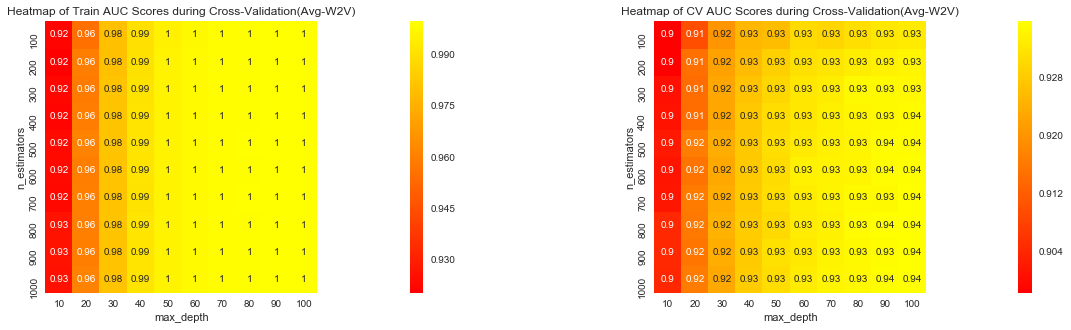

In [88]:
plotCVHeatmap(rf_auc_scores_train_bow, rf_auc_scores_cv_bow, max_depth_range, n_trees_range)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:26<00:00, 2647.47it/s]


No. of samples of each class in Train Set:
0: 35000
1: 35000


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:12<00:00, 2487.20it/s]


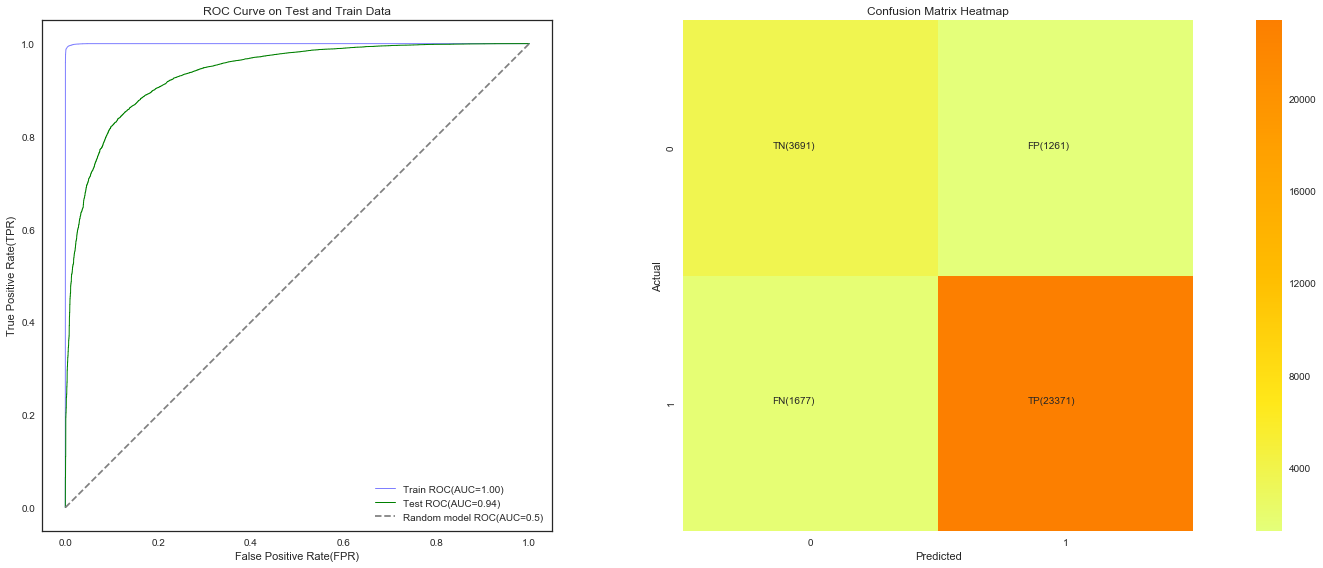

In [132]:
# Running the Classifier on Test Set using optimal hyperparameters obtained during cross-validation
# n_estimators=1000, max_depth=100
# Fetching a class balanced Train Set of 70K samples
warnings.filterwarnings('ignore')
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))

# Fetching a Test set of 21K samples
X_test, y_test = GetTestSet(30000, cv=False)
# Vectorizing the Train and Test Sets
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vect.fit(X_train)
X_train = count_vect.transform(X_train)
X_test = count_vect.transform(X_test)
clf_bow = RandomForestClassifier(n_estimators=1000, max_depth=100, n_jobs=-1)
clf_bow.fit(X_train, y_train)

# Plotting Train and Test ROC curves using TPR and FPR values at different thre sholds of probabilities of class labels
y_train_pred = clf_bow.predict_proba(X_train)[:,1]
y_pred = clf_bow.predict_proba(X_test)[:,1]
cm =  confusion_matrix(y_test, clf_bow.predict(X_test))
plotROCandCM(y_train, y_train_pred, y_test, y_pred, cm)

### [5.1.2] Wordcloud of top 20 important features from<font color='red'> SET 1</font>

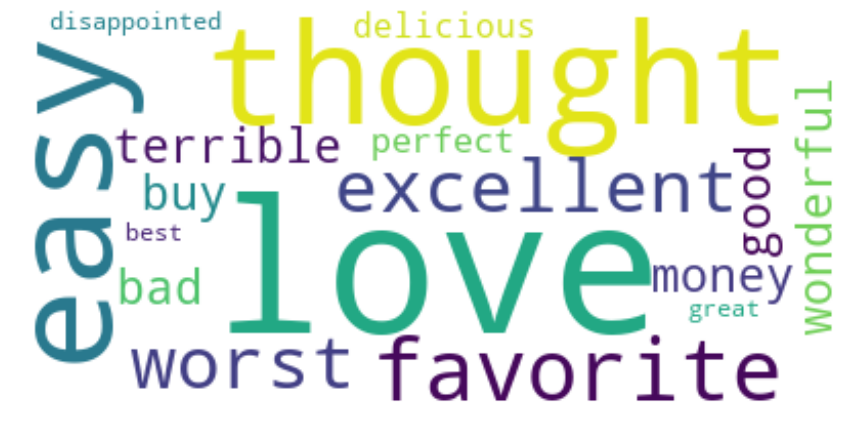

In [134]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from PIL import Image
warnings.filterwarnings("ignore")
imp_features = np.take(count_vect.get_feature_names(), clf_bow.feature_importances_.argsort()[-20:])
wordcloud = WordCloud(background_color="white").generate(" ".join(imp_features))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

### [5.1.3] Applying Random Forests on TFIDF,<font color='red'> SET 2</font>

In [29]:
## Hyperparameter Tuning using Simple Cross-Validation
# Fetch a class balanced Train Set of 70K samples
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))
#Fetching a CV set of 30K samples
X_cv, y_cv = GetTestSet(30000)
# Vectorizing the Train and CV Sets
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tfidf_vect.fit(X_train)
X_train = tfidf_vect.transform(X_train)
X_cv = tfidf_vect.transform(X_cv)

rf_auc_scores_train_tfidf = np.zeros([10,10]); rf_auc_scores_cv_tfidf = np.zeros([10,10])
max_depth_range = np.linspace(10, 100, 10, dtype=np.int32)
n_trees_range = np.linspace(100, 1000, 10, dtype=np.int32)
# Simple Cross-Validation for different values of Hyperparameter C and gamma
i=0
for n_trees in tqdm(n_trees_range):
    j=0
    for max_depth in max_depth_range:
        clf = RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth, n_jobs=-1, warm_start=True)
        clf.fit(X_train, y_train)
        rf_auc_scores_train_tfidf[i,j] = metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        rf_auc_scores_cv_tfidf[i,j] = metrics.roc_auc_score(y_cv, clf.predict_proba(X_cv)[:,1])
        j += 1
    i += 1

  1%|          | 283/30000 [00:00<00:10, 2811.91it/s]

No. of samples of each class in Train Set:
0: 35000
1: 35000


100%|██████████| 10/10 [1:44:17<00:00, 878.91s/it]


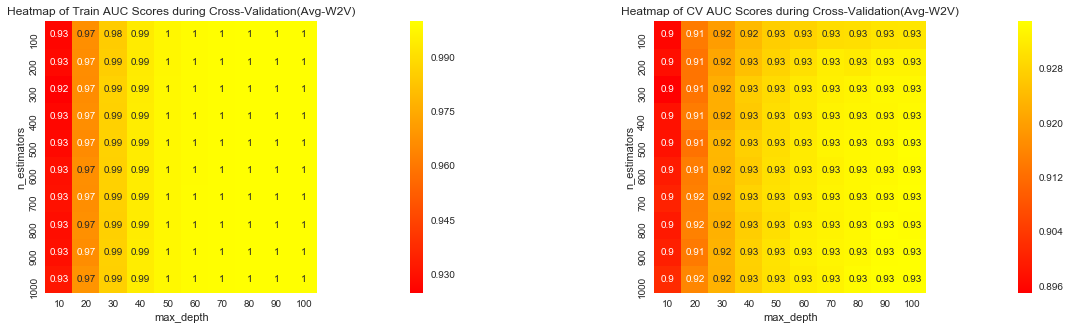

In [90]:
plotCVHeatmap(rf_auc_scores_train_tfidf, rf_auc_scores_cv_tfidf, max_depth_range, n_trees_range)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:27<00:00, 2555.98it/s]


No. of samples of each class in Train Set:
0: 35000
1: 35000


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:11<00:00, 2563.94it/s]


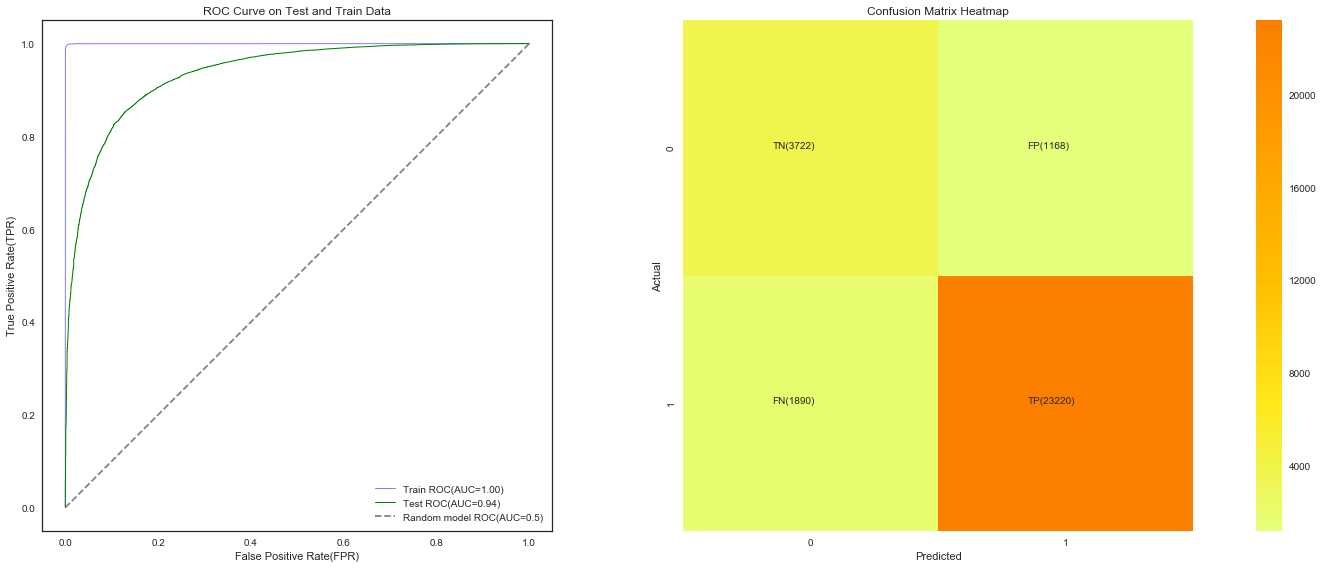

In [37]:
# Running the Classifier on Test Set using optimal hyperparameters obtained during cross-validation
# n_estimators=1000, max_depth=100
# Fetching a class balanced Train Set of 70K samples
warnings.filterwarnings('ignore')
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))

# Fetching a Test set of 21K samples
X_test, y_test = GetTestSet(30000, cv=False)
# Vectorizing the Train and Test Sets
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tfidf_vect.fit(X_train)
X_train = tfidf_vect.transform(X_train)
X_test = tfidf_vect.transform(X_test)
clf = RandomForestClassifier(n_estimators=1000, max_depth=100, n_jobs=-1)
clf.fit(X_train, y_train)

# Plotting Train and Test ROC curves using TPR and FPR values at different thre sholds of probabilities of class labels
y_train_pred = clf.predict_proba(X_train)[:,1]
y_pred = clf.predict_proba(X_test)[:,1]
cm =  confusion_matrix(y_test, clf.predict(X_test))
plotROCandCM(y_train, y_train_pred, y_test, y_pred, cm)

### [5.1.4] Wordcloud of top 20 important features from<font color='red'> SET 2</font>

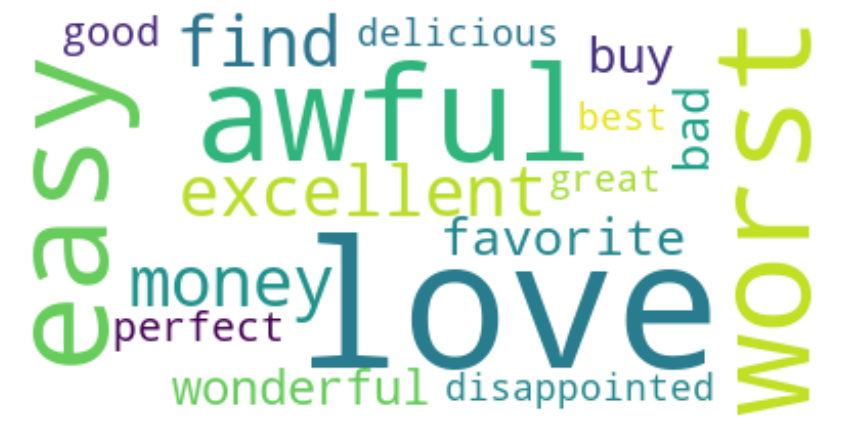

In [43]:
from wordcloud import WordCloud
imp_features = np.take(tfidf_vect.get_feature_names(), clf.feature_importances_.argsort()[-20:])
wordcloud = WordCloud(background_color="white").generate(" ".join(imp_features))
plt.figure(figsize=(12, 12))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.tight_layout()
plt.show()

### [5.1.5] Applying Random Forests on AVG W2V,<font color='red'> SET 3</font>

In [38]:
## Hyperparameter Tuning using Simple Cross-Validation
# Fetch a class balanced Train Set of 70K samples
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))
#Fetching a CV set of 30K samples
X_cv, y_cv = GetTestSet(30000)

# Vectorizing the Train and CV Sets
X_train, X_cv = avg_w2v(X_train, X_cv)

rf_auc_scores_train_avgw2v = np.zeros([10,10]); rf_auc_scores_cv_avgw2v = np.zeros([10,10])
max_depth_range = np.linspace(10, 100, 10, dtype=np.int32)
n_trees_range = np.linspace(100, 1000, 10, dtype=np.int32)
# Simple Cross-Validation for different values of Hyperparameter C and gamma
i=0
for n_trees in tqdm(n_trees_range):
    j=0
    for max_depth in max_depth_range:
        clf = RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth, n_jobs=-1, warm_start=True)
        clf.fit(X_train, y_train)
        rf_auc_scores_train_avgw2v[i,j] = metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        rf_auc_scores_cv_avgw2v[i,j] = metrics.roc_auc_score(y_cv, clf.predict_proba(X_cv)[:,1])
        j += 1
    i += 1
#np.save('rf_auc_scores_train_avgw2v.npy', rf_auc_scores_train_avgw2v)
#np.save('rf_auc_scores_cv_avgw2v.npy', rf_auc_scores_cv_avgw2v)

  1%|          | 272/30000 [00:00<00:10, 2712.02it/s]

No. of samples of each class in Train Set:
0: 35000
1: 35000


  0%|          | 15/70000 [00:00<17:27, 66.80it/s]

Vectorizing the Train Data


  0%|          | 29/30000 [00:00<05:08, 97.17it/s] 

Vectorizing the CV/Test Data


100%|██████████| 10/10 [1:22:41<00:00, 695.64s/it]


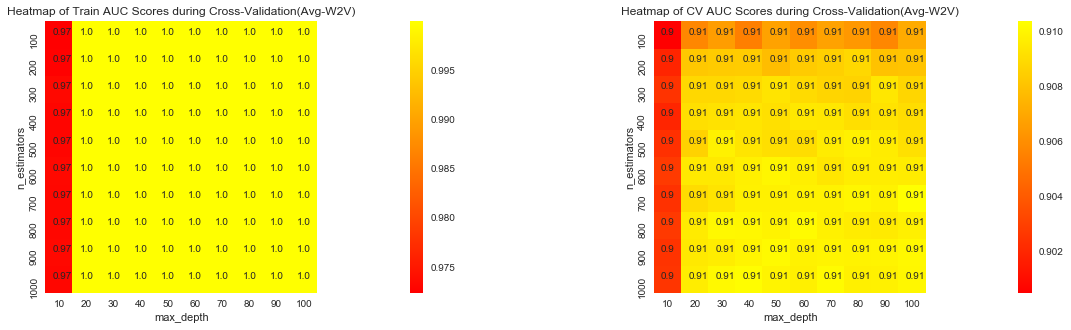

In [136]:
plotCVHeatmap(rf_auc_scores_train_avgw2v, rf_auc_scores_cv_avgw2v, max_depth_range, n_trees_range)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:26<00:00, 2622.68it/s]


No. of samples of each class in Train Set:
0: 35000
1: 35000


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:11<00:00, 2556.53it/s]


Vectorizing the Train Data


100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:01<00:00, 576.40it/s]


Vectorizing the CV/Test Data


100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:58<00:00, 514.65it/s]


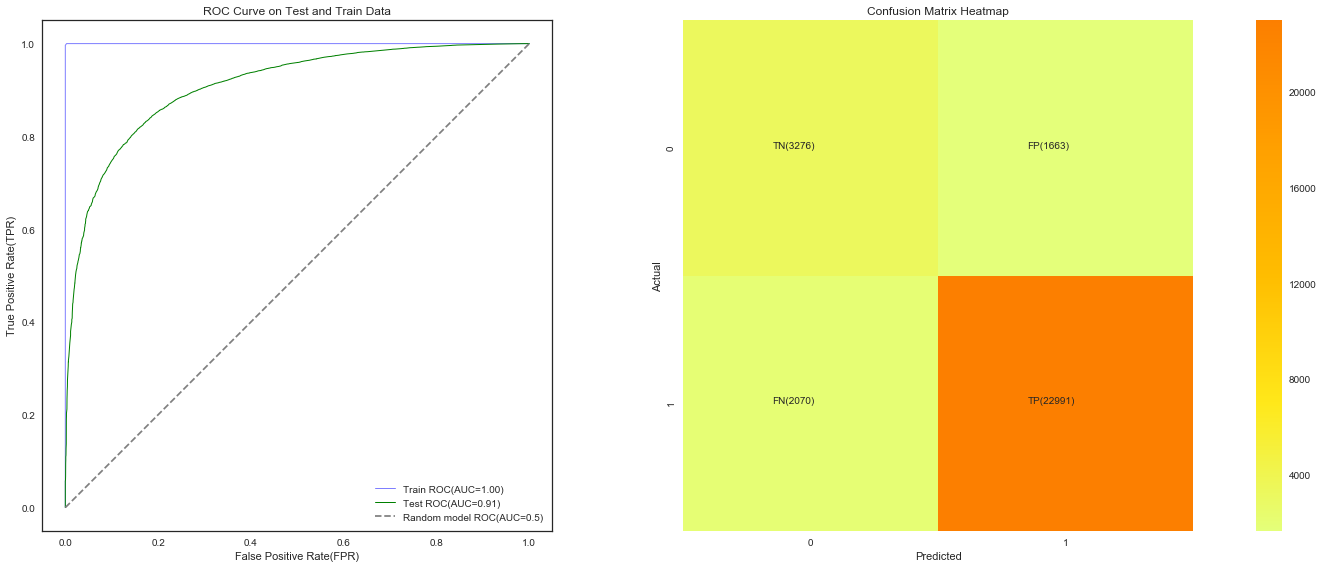

In [145]:
# Running the Classifier on Test Set using optimal hyperparameters obtained during cross-validation
# n_estimators=1000, max_depth=100
# Fetching a class balanced Train Set of 70K samples
warnings.filterwarnings('ignore')
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))

# Fetching a Test set of 21K samples
X_test, y_test = GetTestSet(30000, cv=False)
# Vectorizing the Train and Test Sets
X_train, X_test = avg_w2v(X_train, X_test)
# Fitting the Classifier
clf_agvw2v = RandomForestClassifier(n_estimators=1000, max_depth=100, n_jobs=-1)
clf_agvw2v.fit(X_train, y_train)

# Plotting Train and Test ROC curves using TPR and FPR values at different thre sholds of probabilities of class labels
y_train_pred = clf_agvw2v.predict_proba(X_train)[:,1]
y_pred = clf_agvw2v.predict_proba(X_test)[:,1]
cm =  confusion_matrix(y_test, clf_agvw2v.predict(X_test))
plotROCandCM(y_train, y_train_pred, y_test, y_pred, cm)

### [5.1.6] Applying Random Forests on TFIDF W2V,<font color='red'> SET 4</font>

In [39]:
## Hyperparameter Tuning using Simple Cross-Validation
# Fetch a class balanced Train Set of 70K samples
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))
#Fetching a CV set of 30K samples
X_cv, y_cv = GetTestSet(30000)

# Vectorizing the Train and CV Sets
X_train, X_cv = tfidf_w2v(X_train, X_cv)

rf_auc_scores_train_tfidfw2v = np.zeros([10,10]); rf_auc_scores_cv_tfidfw2v = np.zeros([10,10])
max_depth_range = np.linspace(10, 100, 10, dtype=np.int32)
n_trees_range = np.linspace(100, 1000, 10, dtype=np.int32)
# Simple Cross-Validation for different values of Hyperparameter C and gamma
i=0
for n_trees in tqdm(n_trees_range):
    j=0
    for max_depth in max_depth_range:
        clf = RandomForestClassifier(n_estimators=n_trees, max_depth=max_depth, n_jobs=-1, warm_start=True)
        clf.fit(X_train, y_train)
        rf_auc_scores_train_tfidfw2v[i,j] = metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        rf_auc_scores_cv_tfidfw2v[i,j] = metrics.roc_auc_score(y_cv, clf.predict_proba(X_cv)[:,1])
        j += 1
    i += 1

  1%|          | 309/30000 [00:00<00:09, 3088.63it/s]

No. of samples of each class in Train Set:
0: 35000
1: 35000


  0%|          | 6/70000 [00:00<40:49, 28.57it/s]

Vectorizing the Train Data


  0%|          | 61/30000 [00:02<20:55, 23.84it/s]

Vectorizing the CV/Test Data


100%|██████████| 10/10 [1:23:08<00:00, 701.18s/it]


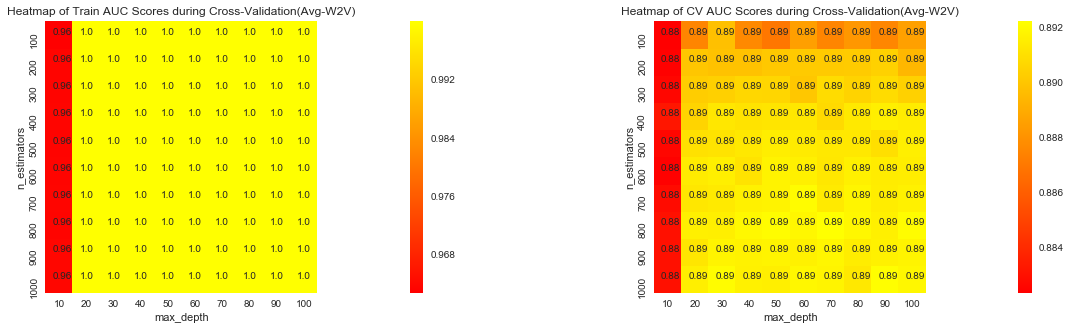

In [146]:
plotCVHeatmap(rf_auc_scores_train_tfidfw2v, rf_auc_scores_cv_tfidfw2v, max_depth_range, n_trees_range)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:26<00:00, 2610.78it/s]


No. of samples of each class in Train Set:
0: 35000
1: 35000


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:12<00:00, 2488.63it/s]


Vectorizing the Train Data


100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [44:02<00:00, 26.49it/s]


Vectorizing the CV/Test Data


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [17:52<00:00, 27.97it/s]


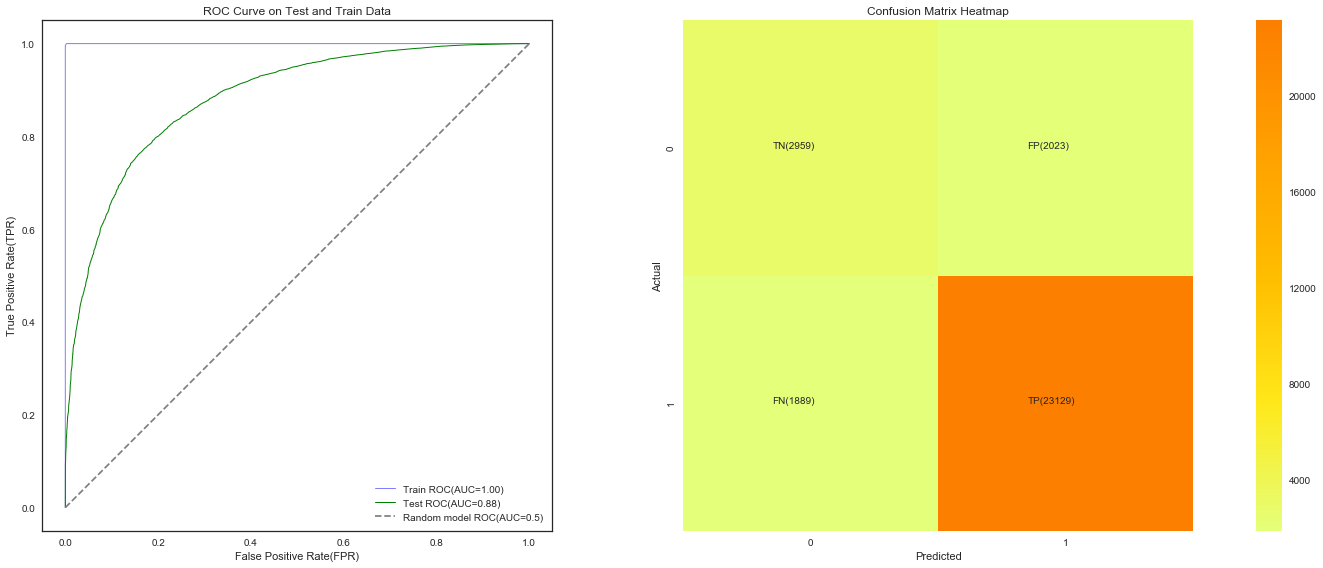

In [35]:
# Running the Classifier on Test Set using optimal hyperparameters obtained during cross-validation
# n_estimators=1000, max_depth=90
# Fetching a class balanced Train Set of 70K samples
warnings.filterwarnings('ignore')
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))

# Fetching a Test set of 21K samples
X_test, y_test = GetTestSet(30000, cv=False)
# Vectorizing the Train and Test Sets
X_train, X_test = tfidf_w2v(X_train, X_test)
# Fitting the Classifier
clf_tfidfw2v = RandomForestClassifier(n_estimators=1000, max_depth=90, n_jobs=-1)
clf_tfidfw2v.fit(X_train, y_train)

# Plotting Train and Test ROC curves using TPR and FPR values at different thre sholds of probabilities of class labels
y_train_pred = clf_tfidfw2v.predict_proba(X_train)[:,1]
y_pred = clf_tfidfw2v.predict_proba(X_test)[:,1]
cm =  confusion_matrix(y_test, clf_tfidfw2v.predict(X_test))
plotROCandCM(y_train, y_train_pred, y_test, y_pred, cm)

## [5.2] Applying GBDT using XGBOOST

### [5.2.1] Applying XGBOOST on BOW,<font color='red'> SET 1</font>

In [64]:
## Hyperparameter Tuning using Simple Cross-Validation
# Fetch a class balanced Train Set of 70K samples
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))
#Fetching a CV set of 30K samples
X_cv, y_cv = GetTestSet(30000)
# Vectorizing the Train and CV Sets
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vect.fit(X_train)
X_train = count_vect.transform(X_train)
X_cv = count_vect.transform(X_cv)

#data_mat = xgb.DMatrix(data=X_train, label=y_train)
xgb_auc_scores_train_bow = np.zeros([10,10]); xgb_auc_scores_cv_bow = np.zeros([10,10])
max_depth_range = np.linspace(10, 100, 10, dtype=np.int32)
n_trees_range = np.linspace(100, 1000, 10, dtype=np.int32)
# Simple Cross-Validation for different values of Hyperparameter C and gamma
i=0
for n_trees in tqdm(n_trees_range):
    j=0
    for max_depth in max_depth_range:
        clf = XGBClassifier(max_depth=max_depth, n_estimators=n_trees, n_jobs=4)
        clf.fit(X_train, y_train)
        xgb_auc_scores_train_bow[i,j] = metrics.roc_auc_score(y_train, clf.predict_proba(X_train)[:,1])
        xgb_auc_scores_cv_bow[i,j] = metrics.roc_auc_score(y_cv, clf.predict_proba(X_cv)[:,1])
        j += 1
    i += 1

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:27<00:00, 2528.63it/s]


No. of samples of each class in Train Set:
0: 35000
1: 35000


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [8:23:45<00:00, 4122.97s/it]


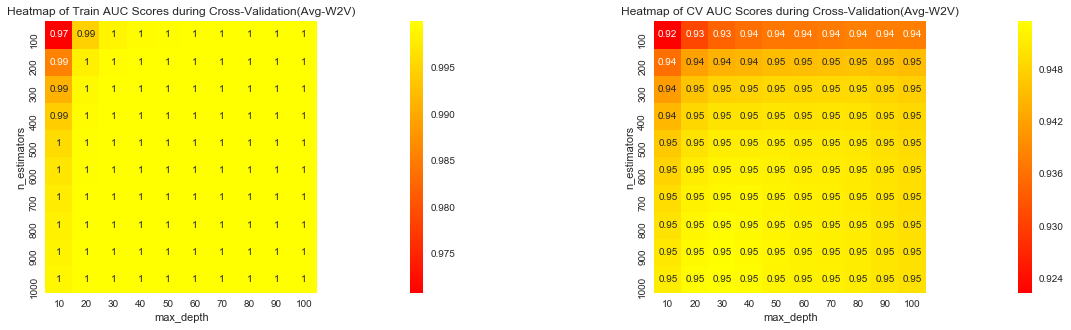

In [105]:
plotCVHeatmap(xgb_auc_scores_train_bow, xgb_auc_scores_cv_bow, max_depth_range, n_trees_range)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:27<00:00, 2506.59it/s]


No. of samples of each class in Train Set:
0: 35000
1: 35000


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:11<00:00, 2510.44it/s]


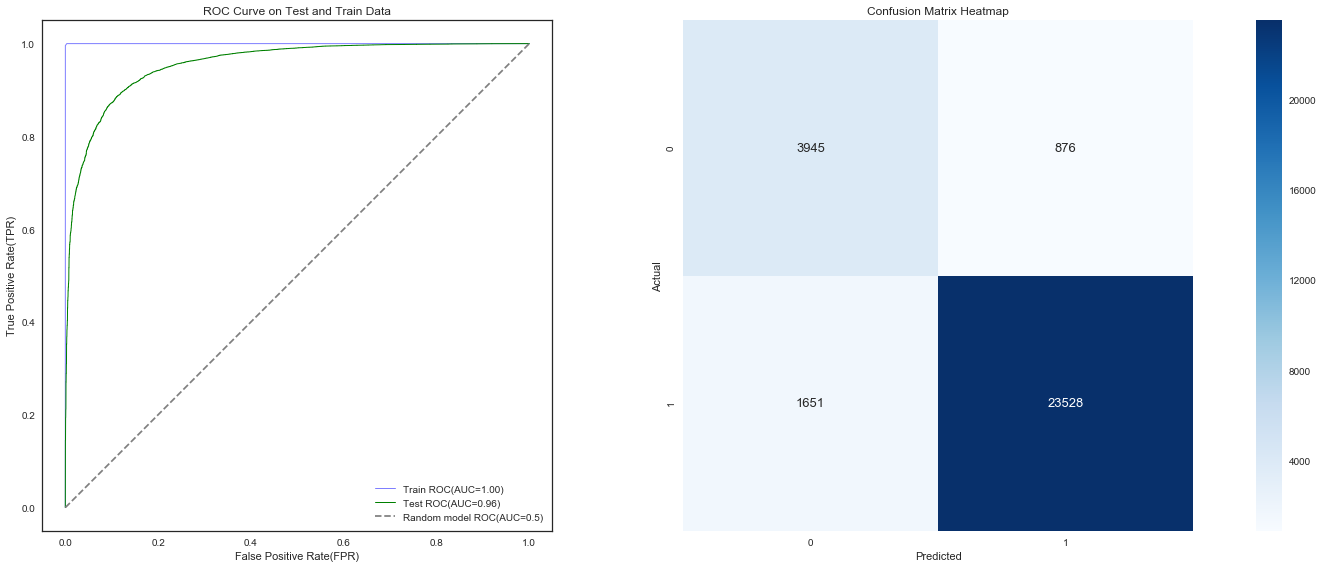

In [106]:
# Running the Classifier on Test Set using optimal hyperparameters obtained during cross-validation
# max_depth=30, n_estimators=1000
# Fetching a class balanced Train Set of 70K samples

warnings.filterwarnings('ignore')
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))

# Fetching a Test set of 30K samples
X_test, y_test = GetTestSet(30000, cv=False)
# Vectorizing the Train and Test Sets
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
count_vect.fit(X_train)
X_train = count_vect.transform(X_train)
X_test = count_vect.transform(X_test)
# Fitting the Classifier
xgb_clf_bow = XGBClassifier(max_depth=30, n_estimators=1000, n_jobs=4)
xgb_clf_bow.fit(X_train, y_train)

# Plotting Train and Test ROC curves using TPR and FPR values at different thre sholds of probabilities of class labels
y_train_pred = xgb_clf_bow.predict_proba(X_train)[:,1]
y_pred = xgb_clf_bow.predict_proba(X_test)[:,1]
cm =  confusion_matrix(y_test, xgb_clf_bow.predict(X_test))

plotROCandCM(y_train, y_train_pred, y_test, y_pred, cm, cmap='Blues')

### [5.2.2] Applying XGBOOST on TFIDF,<font color='red'> SET 2</font>

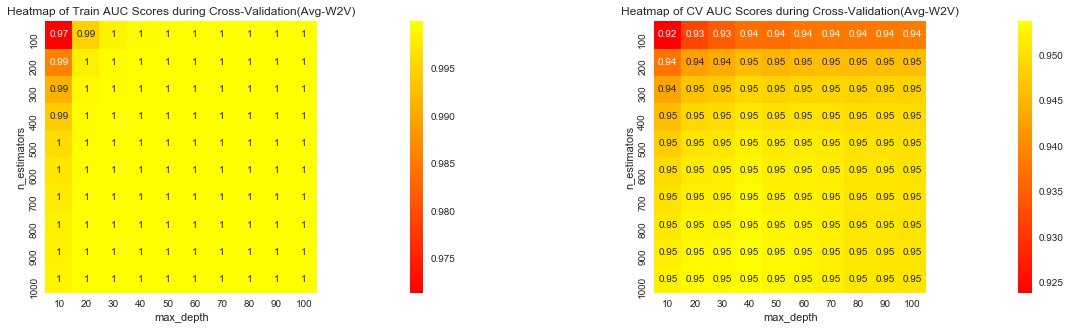

In [70]:
plotCVHeatmap(xgb_auc_scores_train_tfidf, xgb_auc_scores_cv_tfidf, max_depth_range, n_trees_range)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:28<00:00, 2497.89it/s]


No. of samples of each class in Train Set:
0: 35000
1: 35000


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:11<00:00, 2516.96it/s]


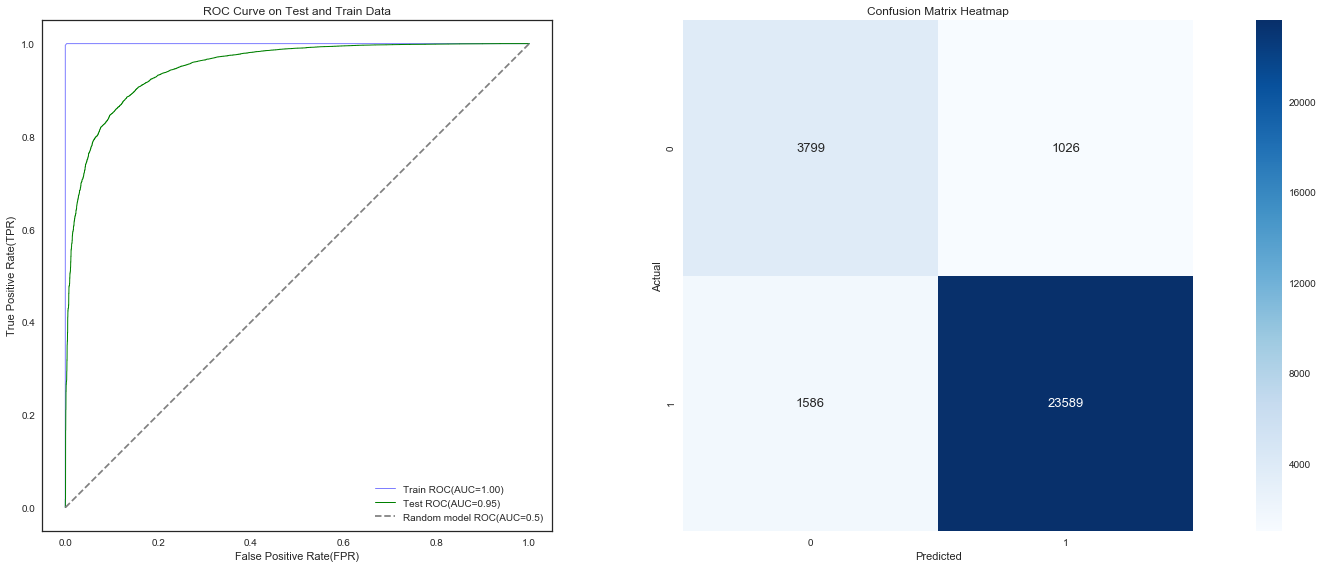

In [71]:
# Running the Classifier on Test Set using optimal hyperparameters obtained during cross-validation
# max_depth=40, n_estimators=700
# Fetching a class balanced Train Set of 70K samples

warnings.filterwarnings('ignore')
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))

# Fetching a Test set of 30K samples
X_test, y_test = GetTestSet(30000, cv=False)
# Vectorizing the Train and Test Sets
tfidf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
tfidf_vect.fit(X_train)
X_train = tfidf_vect.transform(X_train)
X_test = tfidf_vect.transform(X_test)
# Fitting the Classifier
xgb_clf_tfidf = XGBClassifier(max_depth=40, n_estimators=700, n_jobs=4)
xgb_clf_tfidf.fit(X_train, y_train)

# Plotting Train and Test ROC curves using TPR and FPR values at different thre sholds of probabilities of class labels
y_train_pred = xgb_clf_tfidf.predict_proba(X_train)[:,1]
y_pred = xgb_clf_tfidf.predict_proba(X_test)[:,1]
cm =  confusion_matrix(y_test, xgb_clf_tfidf.predict(X_test))

plotROCandCM(y_train, y_train_pred, y_test, y_pred, cm, cmap='Blues')

### [5.2.3] Applying XGBOOST on AVG W2V,<font color='red'> SET 3</font>

In [35]:
## Hyperparameter Tuning using Simple Cross-Validation
# Fetch a class balanced Train Set of 70K samples

X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))
#Fetching a CV set of 30K samples
X_cv, y_cv = GetTestSet(30000)
# Vectorizing the Train and CV Sets
X_train, X_cv = avg_w2v(X_train, X_cv)

#data_mat = xgb.DMatrix(data=X_train, label=y_train)
xgb_auc_scores_train_avgw2v = np.zeros([10,10]); xgb_auc_scores_cv_avgw2v = np.zeros([10,10])
max_depth_range = np.linspace(5, 50, 10, dtype=np.int32)
n_trees_range = np.linspace(100, 1000, 10, dtype=np.int32)
# Simple Cross-Validation for different values of Hyperparameter C and gamma
i=0
for n_trees in tqdm(n_trees_range):
    j=0
    for max_depth in max_depth_range:
        clf = XGBClassifier(max_depth=max_depth, n_estimators=n_trees, n_jobs=8)
        clf.fit(np.array(X_train), np.array(y_train))
        xgb_auc_scores_train_avgw2v[i,j] = metrics.roc_auc_score(y_train, clf.predict_proba(np.array(X_train))[:,1])
        xgb_auc_scores_cv_avgw2v[i,j] = metrics.roc_auc_score(y_cv, clf.predict_proba(np.array(X_cv))[:,1])
        j += 1
    i += 1

  1%|          | 259/30000 [00:00<00:11, 2586.52it/s]

No. of samples of each class in Train Set:
0: 35000
1: 35000


  0%|          | 25/70000 [00:00<09:37, 121.20it/s]

Vectorizing the Train Data


  0%|          | 20/30000 [00:00<05:11, 96.32it/s]

Vectorizing the CV/Test Data


100%|██████████| 10/10 [3:54:30<00:00, 1885.84s/it] 


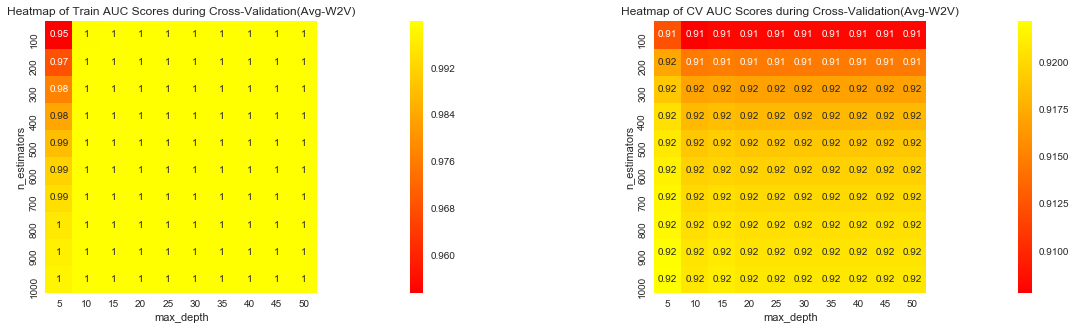

In [81]:
plotCVHeatmap(xgb_auc_scores_train_avgw2v, xgb_auc_scores_cv_avgw2v, max_depth_range, n_trees_range)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:31<00:00, 2208.11it/s]


No. of samples of each class in Train Set:
0: 35000
1: 35000


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:14<00:00, 2135.32it/s]


Vectorizing the Train Data


100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [01:59<00:00, 586.68it/s]


Vectorizing the CV/Test Data


100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [00:54<00:00, 546.14it/s]


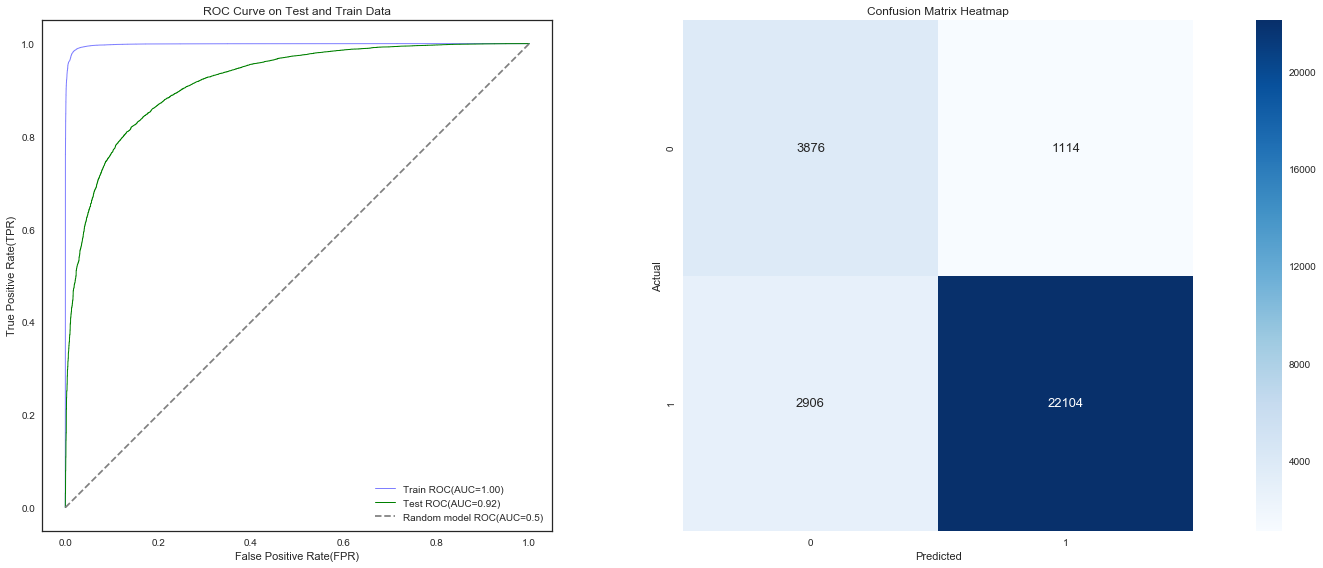

In [82]:
# Running the Classifier on Test Set using optimal hyperparameters obtained during cross-validation
# max_depth=5, n_estimators=1000
# Fetching a class balanced Train Set of 70K samples

warnings.filterwarnings('ignore')
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))

# Fetching a Test set of 30K samples
X_test, y_test = GetTestSet(30000, cv=False)
# Vectorizing the Train and Test Sets
X_train, X_test = avg_w2v(X_train, X_test)
# Fitting the Classifier
xgb_clf_avgw2v = XGBClassifier(max_depth=5, n_estimators=1000, n_jobs=4)
xgb_clf_avgw2v.fit(np.array(X_train), y_train)

# Plotting Train and Test ROC curves using TPR and FPR values at different thre sholds of probabilities of class labels
y_train_pred = xgb_clf_avgw2v.predict_proba(np.array(X_train))[:,1]
y_pred = xgb_clf_avgw2v.predict_proba(np.array(X_test))[:,1]
cm =  confusion_matrix(y_test, xgb_clf_avgw2v.predict(np.array(X_test)))

plotROCandCM(y_train, y_train_pred, y_test, y_pred, cm, cmap='Blues')

### [5.2.4] Applying XGBOOST on TFIDF W2V,<font color='red'> SET 4</font>

In [36]:
## Hyperparameter Tuning using Simple Cross-Validation
# Fetch a class balanced Train Set of 70K samples

X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))
#Fetching a CV set of 30K samples
X_cv, y_cv = GetTestSet(30000)
# Vectorizing the Train and CV Sets
X_train, X_cv = tfidf_w2v(X_train, X_cv)

#data_mat = xgb.DMatrix(data=X_train, label=y_train)
xgb_auc_scores_train_tfidfw2v = np.zeros([10,10]); xgb_auc_scores_cv_tfidfw2v = np.zeros([10,10])
max_depth_range = np.linspace(5, 50, 10, dtype=np.int32)
n_trees_range = np.linspace(100, 1000, 10, dtype=np.int32)
# Simple Cross-Validation for different values of Hyperparameter C and gamma
i=0
for n_trees in tqdm(n_trees_range):
    j=0
    for max_depth in max_depth_range:
        clf = XGBClassifier(max_depth=max_depth, n_estimators=n_trees, n_jobs=8)
        clf.fit(np.array(X_train), np.array(y_train))
        xgb_auc_scores_train_tfidfw2v[i,j] = metrics.roc_auc_score(y_train, clf.predict_proba(np.array(X_train))[:,1])
        xgb_auc_scores_cv_tfidfw2v[i,j] = metrics.roc_auc_score(y_cv, clf.predict_proba(np.array(X_cv))[:,1])
        j += 1
    i += 1

  1%|          | 309/30000 [00:00<00:09, 3073.38it/s]

No. of samples of each class in Train Set:
0: 35000
1: 35000


  0%|          | 3/70000 [00:00<1:20:13, 14.54it/s]

Vectorizing the Train Data


  0%|          | 9/30000 [00:00<14:39, 34.09it/s]

Vectorizing the CV/Test Data


100%|██████████| 10/10 [3:44:03<00:00, 1815.95s/it] 


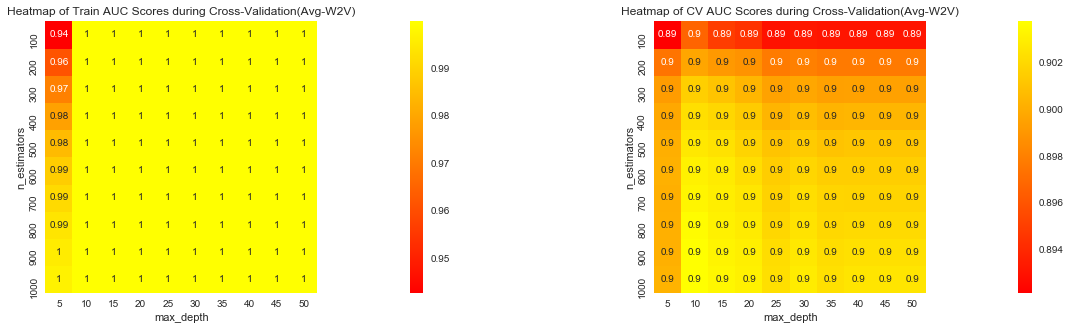

In [85]:
plotCVHeatmap(xgb_auc_scores_train_tfidfw2v, xgb_auc_scores_cv_tfidfw2v, max_depth_range, n_trees_range)

100%|██████████████████████████████████████████████████████████████████████████| 70000/70000 [00:25<00:00, 2694.57it/s]


No. of samples of each class in Train Set:
0: 35000
1: 35000


100%|██████████████████████████████████████████████████████████████████████████| 30000/30000 [00:13<00:00, 2290.43it/s]


Vectorizing the Train Data


100%|████████████████████████████████████████████████████████████████████████████| 70000/70000 [45:50<00:00, 25.45it/s]


Vectorizing the CV/Test Data


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [19:57<00:00, 25.56it/s]


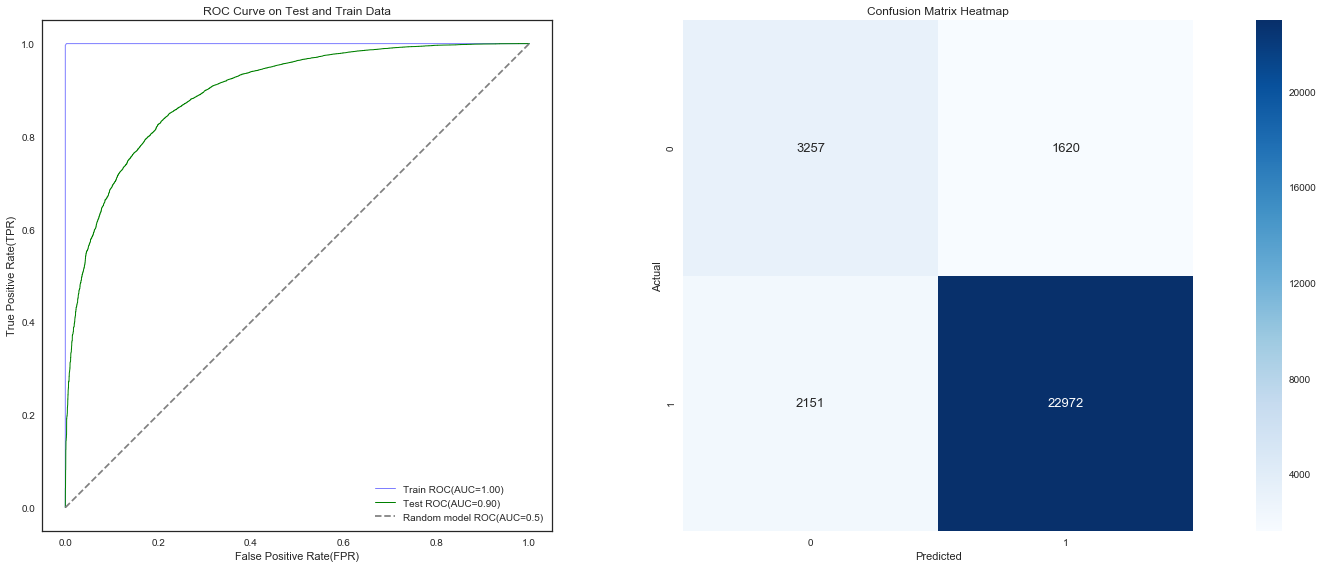

In [34]:
# Running the Classifier on Test Set using optimal hyperparameters obtained during cross-validation
# max_depth=10, n_estimators=1000
# Fetching a class balanced Train Set of 70K samples

warnings.filterwarnings('ignore')
X_train, y_train = GetBalancedSet(70000)
print("No. of samples of each class in Train Set:")
print("0:", y_train.count(0))
print("1:", y_train.count(1))

# Fetching a Test set of 30K samples
X_test, y_test = GetTestSet(30000, cv=False)
# Vectorizing the Train and Test Sets
X_train, X_test = tfidf_w2v(X_train, X_test)
# Fitting the Classifier
xgb_clf_tfidfw2v = XGBClassifier(max_depth=10, n_estimators=1000, n_jobs=4)
xgb_clf_tfidfw2v.fit(np.array(X_train), y_train)

# Plotting Train and Test ROC curves using TPR and FPR values at different thre sholds of probabilities of class labels
y_train_pred = xgb_clf_tfidfw2v.predict_proba(np.array(X_train))[:,1]
y_pred = xgb_clf_tfidfw2v.predict_proba(np.array(X_test))[:,1]
cm =  confusion_matrix(y_test, xgb_clf_tfidfw2v.predict(np.array(X_test)))

plotROCandCM(y_train, y_train_pred, y_test, y_pred, cm, cmap='Blues')

# [6] Conclusions

In [36]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
#x.header = True
x.field_names = ["Vectorizer", "Model", "Hyperparameters", "Test AUC"]
x.add_row(["BoW", "Random Forest", "max_depth=100, n_estimators=1000", "0.94"])
x.add_row(["TFIDF", "Random Forest", "max_depth=100, n_estimators=1000", "0.94"])
x.add_row(["Average Word2Vec", "Random Forest", "max_depth=100, n_estimators=1000", "0.91"])
x.add_row(["TFIDF Weighted Word2Vec", "Random Forest", "max_depth=90, n_estimators=1000", "0.88"])
x.add_row(["BoW", "Gradient Boosted Decision Tree", "max_depth=30, n_estimators=1000", "0.96"])
x.add_row(["TFIDF", "Gradient Boosted Decision Tree", "max_depth=40, n_estimators=700", "0.95"])
x.add_row(["Average Word2Vec", "Gradient Boosted Decision Tree", "max_depth=5, n_estimators=1000", "0.92"])
x.add_row(["TFIDF Weighted Word2Vec", "Gradient Boosted Decision Tree", "max_depth=10, n_estimators=1000", "0.90"])
print(x)

+-------------------------+--------------------------------+----------------------------------+----------+
|        Vectorizer       |             Model              |         Hyperparameters          | Test AUC |
+-------------------------+--------------------------------+----------------------------------+----------+
|           BoW           |         Random Forest          | max_depth=100, n_estimators=1000 |   0.94   |
|          TFIDF          |         Random Forest          | max_depth=100, n_estimators=1000 |   0.94   |
|     Average Word2Vec    |         Random Forest          | max_depth=100, n_estimators=1000 |   0.91   |
| TFIDF Weighted Word2Vec |         Random Forest          | max_depth=90, n_estimators=1000  |   0.88   |
|           BoW           | Gradient Boosted Decision Tree | max_depth=30, n_estimators=1000  |   0.96   |
|          TFIDF          | Gradient Boosted Decision Tree |  max_depth=40, n_estimators=700  |   0.95   |
|     Average Word2Vec    | Gradient 